# Análise para departamento médico (doenças)
Objetivo: Identificar doenças a partir de imagens médicas

## Importação de bibliotecas e carga de dados

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers, models, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

2022-06-06 20:05:26.803342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 20:05:26.803375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


O dado aqui será normalizado e configurado para o treinamento

In [2]:
image_generator = ImageDataGenerator(rescale=1./255)

train_generator = image_generator.flow_from_directory(batch_size=40, directory="./Train", shuffle=True, 
                                                      target_size=(256, 256), class_mode="categorical", subset="training")

Found 532 images belonging to 4 classes.


Classes: Covid-19, Normal, pneumonia viral, pneumonia bacteraial

## Visualização de uma amostra do dado

In [3]:
train_images, train_labels = next(train_generator)
label_names = {0: "covid-19", 1: "Normal", 2: "viral pneumonia", 3: "bacterial pneumonia"}

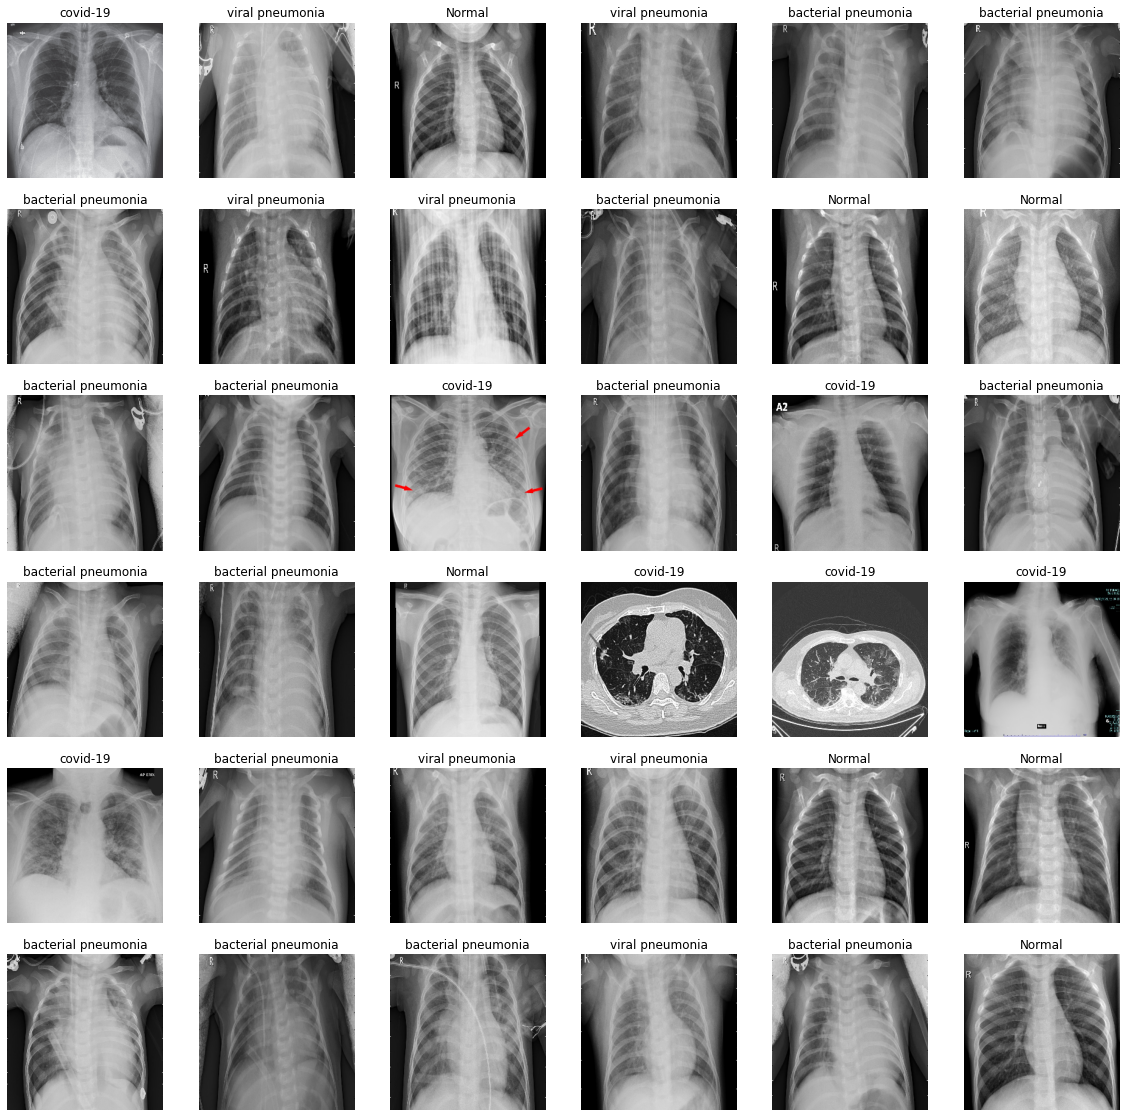

In [4]:
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
axes = axes.ravel()
for i in range(36):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis("off")

## Configuração da ResNet50
Ela será usada para identificar e classificar as doenças

### Carga da ResNet50 pré-treinada (transfer learning) e configuração

In [30]:
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(256, 256, 3)))

In [31]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

###  Botando as ultimas 10 camadas para serem as unicas treinaveis da parte convolucional

In [32]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

### Configurando a parte da MLP

In [40]:
head_model = base_model.output
head_model = layers.AveragePooling2D()(head_model)
head_model = layers.Flatten()(head_model)
head_model = layers.Dense(256, "relu")(head_model)
head_model = layers.Dropout(0.2)(head_model)
head_model = layers.Dense(256, "relu")(head_model)
head_model = layers.Dropout(0.2)(head_model)
head_model = layers.Dense(4, "softmax")(head_model)

model = models.Model(base_model.input, head_model)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(learning_rate=0.0001), metrics="acc")
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Treinando a rede neural

In [41]:
callback_list = [
    callbacks.ModelCheckpoint(filepath="weights.hdf5")
]

Como o conjunto dados de treinamento é muito pequeno, não será utilizado o conjunto de teste 

In [42]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory="./Train", shuffle=True, 
                                                      target_size=(256, 256), class_mode="categorical", subset="training")

Found 532 images belonging to 4 classes.


In [43]:
history = model.fit(train_generator, epochs=100, callbacks=callback_list)

Epoch 1/100
133/133 [==============================] - 24s 170ms/step - loss: 0.8407 - acc: 0.6654
Epoch 2/100
133/133 [==============================] - 22s 168ms/step - loss: 0.6143 - acc: 0.7519
Epoch 3/100
133/133 [==============================] - 23s 171ms/step - loss: 0.5568 - acc: 0.8083
Epoch 4/100
133/133 [==============================] - 23s 170ms/step - loss: 0.5222 - acc: 0.7989
Epoch 5/100
133/133 [==============================] - 23s 169ms/step - loss: 0.4779 - acc: 0.8365
Epoch 6/100
133/133 [==============================] - 23s 169ms/step - loss: 0.4849 - acc: 0.8233
Epoch 7/100
133/133 [==============================] - 23s 170ms/step - loss: 0.4668 - acc: 0.8083
Epoch 8/100
133/133 [==============================] - 23s 169ms/step - loss: 0.4656 - acc: 0.8308
Epoch 9/100
133/133 [==============================] - 29s 214ms/step - loss: 0.3987 - acc: 0.8515
Epoch 10/100
133/133 [==============================] - 23s 173ms/step - loss: 0.4578 - acc: 0.8402
Epoch 11/

133/133 [==============================] - 22s 164ms/step - loss: 0.1884 - acc: 0.9417
Epoch 84/100
133/133 [==============================] - 22s 164ms/step - loss: 0.2040 - acc: 0.9380
Epoch 85/100
133/133 [==============================] - 22s 164ms/step - loss: 0.1997 - acc: 0.9436
Epoch 86/100
133/133 [==============================] - 22s 165ms/step - loss: 0.2501 - acc: 0.9286
Epoch 87/100
133/133 [==============================] - 22s 164ms/step - loss: 0.2427 - acc: 0.9286
Epoch 88/100
133/133 [==============================] - 22s 164ms/step - loss: 0.2095 - acc: 0.9398
Epoch 89/100
133/133 [==============================] - 22s 164ms/step - loss: 0.2203 - acc: 0.9398
Epoch 90/100
133/133 [==============================] - 22s 163ms/step - loss: 0.1964 - acc: 0.9417
Epoch 91/100
133/133 [==============================] - 22s 166ms/step - loss: 0.1988 - acc: 0.9380
Epoch 92/100
133/133 [==============================] - 22s 164ms/step - loss: 0.1977 - acc: 0.9511
Epoch 93/100


### Avaliação da rede neural

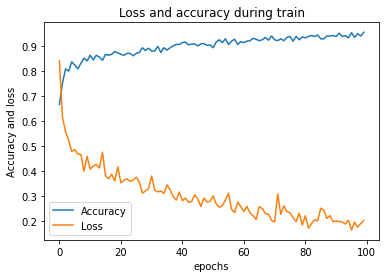

In [44]:
plt.plot(history.history["acc"], label="Accuracy")
plt.plot(history.history["loss"], label="Loss")
plt.title("Loss and accuracy during train")
plt.xlabel("epochs")
plt.ylabel("Accuracy and loss")
plt.legend()

In [48]:
test_root_path = "./Test"

image_generator_test = ImageDataGenerator(rescale=1./255)
test_generator = image_generator_test.flow_from_directory(batch_size=4, directory=test_root_path, shuffle=True, 
                                                      target_size=(256, 256), class_mode="categorical")

Found 40 images belonging to 4 classes.


In [49]:
evaluate = model.evaluate(test_generator, verbose=1)

10/10 [==============================] - 2s 116ms/step - loss: 2.1895 - acc: 0.7000


#### Comparação das classes originais e preditas

In [50]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_root_path))):
    for item in os.listdir(os.path.join(test_root_path, str(i))):
        img = cv2.imread(os.path.join(test_root_path, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1, 256, 256, 3)
        predict = np.argmax(model.predict(img))
        prediction.append(predict)
        original.append(i)

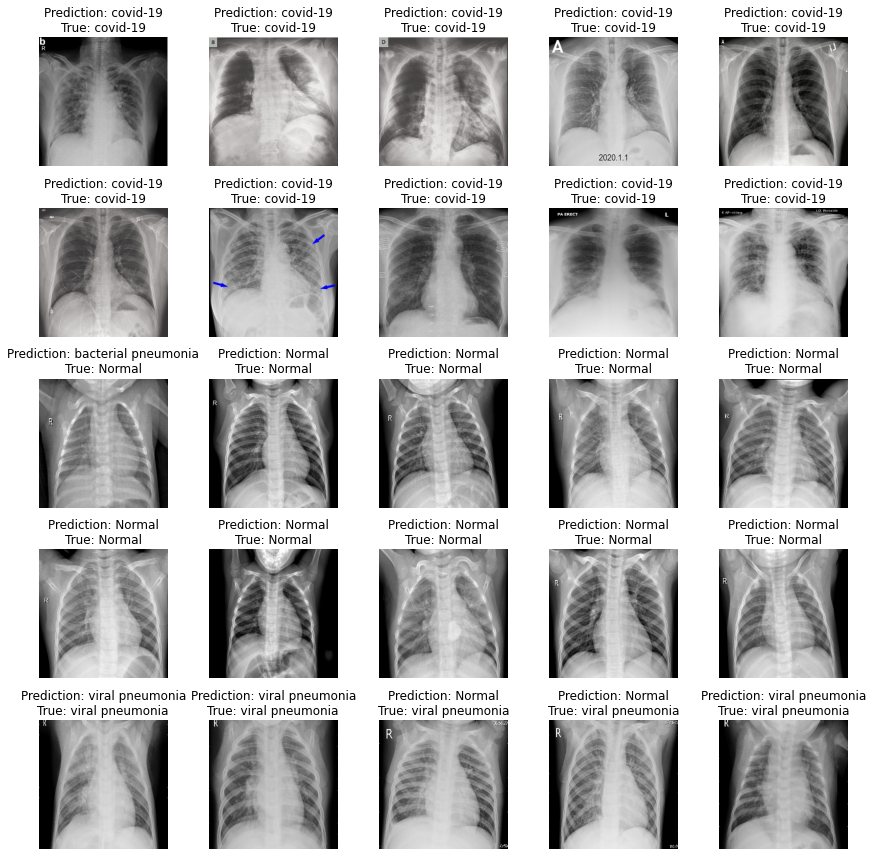

In [52]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i in range(25):
    axes[i].imshow(image[i])
    axes[i].set_title(f"Prediction: {label_names[prediction[i]]}\nTrue: {label_names[original[i]]}")
    axes[i].axis("off")
plt.tight_layout()

In [53]:
label_names

{0: 'covid-19', 1: 'Normal', 2: 'viral pneumonia', 3: 'bacterial pneumonia'}

<AxesSubplot:>

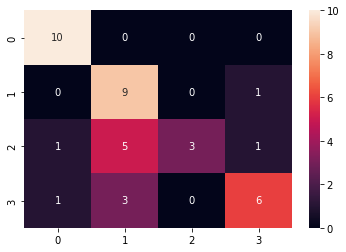

In [54]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True)

In [55]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.53      0.90      0.67        10
           2       1.00      0.30      0.46        10
           3       0.75      0.60      0.67        10

    accuracy                           0.70        40
   macro avg       0.78      0.70      0.68        40
weighted avg       0.78      0.70      0.68        40



### Salvando o modelo

In [4]:
model.save("./resnet_model")

2022-06-06 20:08:01.269523: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./resnet_model/assets


/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Simulando o uso do modelo em produção

### Carga do modelo

In [5]:
model_loaded = models.load_model("./resnet_model")

In [6]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### Carga de uma imagem

In [7]:
img = cv2.imread("./Test/2/person272_virus_559.jpeg")
img.shape

(1256, 1704, 3)

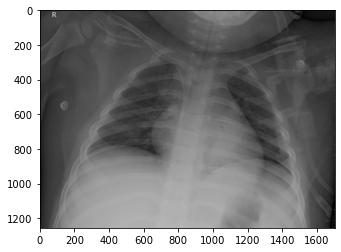

In [8]:
plt.imshow(img)

#### Adequação da imagem para ser aceita pelo modelo

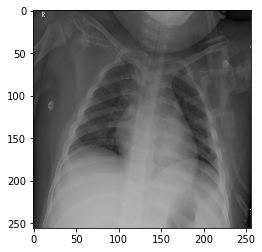

In [9]:
img = cv2.resize(img, (256, 256))
plt.imshow(img)

In [10]:
img = img/255
img

array([[[0.19607843, 0.19607843, 0.19607843],
        [0.20392157, 0.20392157, 0.20392157],
        [0.20784314, 0.20784314, 0.20784314],
        ...,
        [0.07843137, 0.07843137, 0.07843137],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.07843137, 0.07843137, 0.07843137]],

       [[0.19215686, 0.19215686, 0.19215686],
        [0.19607843, 0.19607843, 0.19607843],
        [0.19607843, 0.19607843, 0.19607843],
        ...,
        [0.07843137, 0.07843137, 0.07843137],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.07843137, 0.07843137, 0.07843137]],

       [[0.18823529, 0.18823529, 0.18823529],
        [0.19215686, 0.19215686, 0.19215686],
        [0.2       , 0.2       , 0.2       ],
        ...,
        [0.08235294, 0.08235294, 0.08235294],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.0745098 , 0.0745098 , 0.0745098 ]],

       ...,

       [[0.12156863, 0.12156863, 0.12156863],
        [0.15294118, 0.15294118, 0.15294118],
        [0.17254902, 0

In [11]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

### Predição da classe

In [12]:
predict_raw = model_loaded.predict(img)
predict_raw

2022-06-06 20:09:16.098209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[9.9873906e-01, 2.8105838e-05, 1.0449989e-03, 1.8790222e-04]],
      dtype=float32)

In [13]:
predict = np.argmax(predict_raw)
predict

0

In [15]:
label_names = {0: "covid-19", 1: "Normal", 2: "viral pneumonia", 3: "bacterial pneumonia"}
print(f"Doença: {label_names[predict]} - confiança: {float(predict_raw[0][predict])}")

Doença: covid-19 - confiança: 0.9987390637397766
